In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.distributions import Normal as norm

import torchvision.datasets as datasets
import torchvision.transforms as transforms

from termcolor import colored

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Process

In [3]:
# trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((50,), (1.0,))])
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0,), (1.0,))])

In [4]:
# if not exist, download mnist dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, transform=trans, download=True)
mnist_testset = datasets.MNIST(root='./data', train=False, transform=trans, download=True)

In [5]:
batch_size = 128
N = len(mnist_trainset)
N

60000

In [6]:
N_test = len(mnist_testset)
N_test

10000

In [7]:
train_loader = torch.utils.data.DataLoader(
                 dataset=mnist_trainset,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=mnist_testset,
                batch_size=N_test,
                shuffle=False)

In [8]:
FF = nn.Flatten()

In [9]:
c = 0
for batch_idx, (example_data, example_targets) in enumerate(train_loader):
    c += 1
    print(example_data.shape)
    print(example_targets.shape)
    print("Flatten", FF(example_data).shape)
    if c ==2:   
        break

torch.Size([128, 1, 28, 28])
torch.Size([128])
Flatten torch.Size([128, 784])
torch.Size([128, 1, 28, 28])
torch.Size([128])
Flatten torch.Size([128, 784])


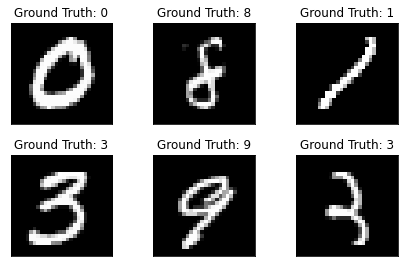

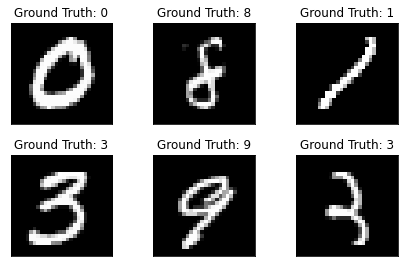

In [10]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
fig

# Main functions

In [11]:
class Gaussian(nn.Module):
    def __init__(self, mu, rho):
        super(Gaussian, self).__init__()
        self.norm   = norm(0,1)
        self.mu_    = mu
        self.rho_   = rho
        self.sigma_ = torch.ones(self.mu_.shape).to(device)
        
        
    def sample(self):
        self.eps    = eps_scale * self.norm.sample(self.mu_.shape).type(self.mu_.type()).to(device)
        self.sigma_ = eps_scale * torch.log(1 + torch.exp(self.rho_)).to(device)
        self.W      = self.mu_  + self.sigma_ * self.eps
        return self.W
            
    def loss(self):
        return (0.5 * self.mu_**2 + 0.5 * eps_scale * self.sigma_ 
                - eps_scale * 0.5 * torch.log(1e-20 + self.sigma_)).sum()

In [12]:
class Blinear(nn.Module):
    def __init__(self, n_input, n_output):
        super(Blinear, self).__init__()
        
        
        self.n_input  = n_input
        self.n_output = n_output
        
        
        
        self.mu    = nn.Parameter(torch.Tensor(n_output, n_input).normal_(0., .05))  # or .01
        self.rho   = nn.Parameter(torch.Tensor(n_output, n_input).uniform_(-3., -3.))
        
        self.W     = Gaussian(self.mu, self.rho)
        
        self.b_mu  = nn.Parameter(torch.Tensor(n_output).normal_(0., .05))
        self.b_rho = nn.Parameter(torch.Tensor(n_output).uniform_(-3., -3.))
        
        self.b     = Gaussian(self.b_mu, self.b_rho)   
        
        
    def forward(self, x):
        
        W = self.W.sample()
        b = self.b.sample()
        
        return F.linear(x, W, b)

In [13]:
class BNet(nn.Module):
    
    def __init__(self, layers, act):
        super(BNet, self).__init__()
        
        self.act = act
        self.fc  = nn.ModuleList()
        self.flatten = nn.Flatten()
        for i in range(len(layers) - 1):
            self.fc.append(Blinear(layers[i], layers[i+1]))  
            
            
    def forward(self,x):
        x = self.flatten(x)
        for i in range(len(self.fc) - 1):
            x = self.fc[i].forward(x) #forward based on Blinear 
            x = self.act(x)
            
        x = F.log_softmax(self.fc[-1](x), dim=1)
        
        return x

In [14]:
class BNN():
    def __init__(self, train_loader, layers, act, n_epochs = 10000):
        
        self.train_loader = train_loader
        self.n_layers = len(layers)
        
        self.nepochs = n_epochs
        self.BNet    = BNet(layers, act)
        
        self.History_learning = []
        
    def get_neg_elbo(self):
        neg_elbo = 0
        for i in range(self.n_layers-1):
            neg_elbo += self.BNet.fc[i].W.loss()
            neg_elbo += self.BNet.fc[i].b.loss()
            
        p_pred = self.BNet(self.x)
        
        return neg_elbo + N/batch_size * F.nll_loss(p_pred, self.y, reduction='sum') #sum or mean?

#         return 1/(N//batch_size) * neg_elbo + N//batch_size * F.nll_loss(p_pred, self.y, reduction='sum')
        
#         loss_1 = 0
#         for i in range(10):
#             loss_1 += p_pred[self.y == i, i].sum()
#         return neg_elbo - N/batch_size * loss_1
        
    
    def train(self, lr, decay, step_size = 1000):
    
        optimizer = torch.optim.Adam(self.BNet.parameters(), lr = lr)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=decay)
        
        
                        
        with torch.no_grad():
            for _, (example_data, example_targets) in enumerate(test_loader):
                A = example_data/126
                b = example_targets
            z = self.BNet(A).detach()
            T_pred = torch.argmax(z, dim = 1)
            self.History_learning.append((T_pred == b).sum()/len(T_pred)) 
        
        for n in range(self.nepochs):
            

            
            for batch_idx, (example_data, example_targets) in enumerate(train_loader):
                
                self.x = example_data/126
                self.y = example_targets
             
                loss = self.get_neg_elbo()
                if batch_idx %100 == 0:
                    print(n, batch_idx)
                    with torch.no_grad():
                        print("Loss = ", loss.item())
                        acc = 0
                        pl = 0
                        for i in range(100):
                            p_pred = self.BNet(self.x).numpy()
                            y_hat = np.argmax(p_pred, axis = 1)
                            acc += (self.y.numpy() == y_hat).astype(int).mean()
                    
                        print(colored('learning rate:{}'.format(optimizer.param_groups[0]['lr']), 'blue'))
                        print(colored('Train accuracy for iteration {} is {}'.format(n, acc/100), 'red'))
#                         print('Predictive log-likelihood for trainat iteration {} is {}'.format(n, pl/100))



                    
                optimizer.zero_grad()
                loss.backward(retain_graph=True)
                optimizer.step()
                scheduler.step()
                
            with torch.no_grad():
                for _, (example_data, example_targets) in enumerate(test_loader):
                    A = example_data/126
                    b = example_targets
                z = self.BNet(A).detach()
                T_pred = torch.argmax(z, dim = 1)
                self.History_learning.append((T_pred == b).sum()/len(T_pred))                

In [15]:
# eps_scale = 1
# for lr in [1e-3, 1e-4, 1e-5]:
#     for l in [400, 800, 1200]:
#         print('---------------------------------------------------------------------')
#         print('---------------------------------------------------------------------')
#         #print(colored("\n\n Start training for lr = {} and hidden_layer size = {}\n\n".format(lr, l), 'green'))
#         print('---------------------------------------------------------------------')
#         print('---------------------------------------------------------------------')
#         model = BNN(train_loader, [784, l, l, 10], act = nn.ReLU(), n_epochs = 20)
#         model.train(lr = lr, decay = 1)
#         #models.append(model)
#         print('---------------------------------------------------------------------')
#         print('---------------------------------------------------------------------')
    
#         for _, (example_data, example_targets) in enumerate(test_loader):
#             A = example_data/126
#             b = example_targets
#         z = model.BNet(A).detach()
#         T_pred = torch.argmax(z, dim = 1)
#         print((T_pred == b).sum()/len(T_pred))

In [16]:
# eps_scale = 1
# for lr in [1e-3, 1e-4, 1e-5]:
#     for l in [400, 800, 1200]:
#         print('---------------------------------------------------------------------')
#         print('---------------------------------------------------------------------')
#         #print(colored("\n\n Start training for lr = {} and hidden_layer size = {}\n\n".format(lr, l), 'green'))
#         print('---------------------------------------------------------------------')
#         print('---------------------------------------------------------------------')
#         model = BNN(train_loader, [784, l, l, 10], act = nn.Tanh(), n_epochs = 20)
#         model.train(lr = lr, decay = 1)
#         #models.append(model)
#         print('---------------------------------------------------------------------')
#         print('---------------------------------------------------------------------')
    
#         for _, (example_data, example_targets) in enumerate(test_loader):
#             A = example_data/126
#             b = example_targets
#         z = model.BNet(A).detach()
#         T_pred = torch.argmax(z, dim = 1)
#         print((T_pred == b).sum()/len(T_pred))

## Vanilla NN training with SGD

In [17]:
# eps_scale = 0 # if it is zero, then the netwok become non Bayesian
# for lr in [1e-3, 1e-4, 1e-5]:
#     for l in [400, 800,1200]:
#         print('---------------------------------------------------------------------')
#         print('---------------------------------------------------------------------')
#         #print(colored("\n\n Start training for lr = {} and hidden_layer size = {}\n\n".format(lr, l), 'green'))
#         print('---------------------------------------------------------------------')
#         print('---------------------------------------------------------------------')
#         model = BNN(train_loader, [784, l, l, 10], act = nn.ReLU(), n_epochs = 2)
#         model.train(lr = lr, decay = 1)
#         #models.append(model)
#         print('---------------------------------------------------------------------')
#         print('---------------------------------------------------------------------')

#         for _, (example_data, example_targets) in enumerate(test_loader):
#             A = example_data/126
#             b = example_targets
#         z = model.BNet(A).detach()
#         T_pred = torch.argmax(z, dim = 1)
#         print('for ReLU(), lr = {}, l={}, acc = {}'.format(lr,l,(T_pred == b).sum()/len(T_pred)))

In [18]:
# eps_scale = 0 # if it is zero, then the netwok become non Bayesian
# for lr in [1e-3, 1e-4, 1e-5]:
#     for l in [400, 800,1200]:
#         print('---------------------------------------------------------------------')
#         print('---------------------------------------------------------------------')
#         #print(colored("\n\n Start training for lr = {} and hidden_layer size = {}\n\n".format(lr, l), 'green'))
#         print('---------------------------------------------------------------------')
#         print('---------------------------------------------------------------------')
#         model = BNN(train_loader, [784, l, l, 10], act = nn.Tanh(), n_epochs = 2)
#         model.train(lr = lr, decay = 1)
#         #models.append(model)
#         print('---------------------------------------------------------------------')
#         print('---------------------------------------------------------------------')

#         for _, (example_data, example_targets) in enumerate(test_loader):
#             A = example_data/126
#             b = example_targets
#         z = model.BNet(A).detach()
#         T_pred = torch.argmax(z, dim = 1)
#         print('for Tanh(), lr = {}, l={}, acc = {}'.format(lr,l,(T_pred == b).sum()/len(T_pred)))

## Bayesian ReLU 

In [19]:
eps_scale = 1
for lr in [1e-3]:
    for l in [1200]:
        print('---------------------------------------------------------------------')
        print('---------------------------------------------------------------------')
        #print(colored("\n\n Start training for lr = {} and hidden_layer size = {}\n\n".format(lr, l), 'green'))
        print('---------------------------------------------------------------------')
        print('---------------------------------------------------------------------')
        model1 = BNN(train_loader, [784, l, l, 10], act = nn.ReLU(), n_epochs = 100)
        model1.train(lr = lr, decay = 1)
        #models.append(model)
        print('---------------------------------------------------------------------')
        print('---------------------------------------------------------------------')
    
        for _, (example_data, example_targets) in enumerate(test_loader):
            A = example_data/126
            b = example_targets
        z = model1.BNet(A).detach()
        T_pred = torch.argmax(z, dim = 1)
        print((T_pred == b).sum()/len(T_pred))

---------------------------------------------------------------------
---------------------------------------------------------------------
---------------------------------------------------------------------
---------------------------------------------------------------------
0 0
Loss =  3824120.75
learning rate:0.001
Train accuracy for iteration 0 is 0.096171875
0 100
Loss =  3713389.5
learning rate:0.001
Train accuracy for iteration 0 is 0.37546875
0 200
Loss =  3566965.5
learning rate:0.001
Train accuracy for iteration 0 is 0.681484375
0 300
Loss =  3473729.0
learning rate:0.001
Train accuracy for iteration 0 is 0.7728125
0 400
Loss =  3402498.75
learning rate:0.001
Train accuracy for iteration 0 is 0.7728125
1 0
Loss =  3330120.25
learning rate:0.001
Train accuracy for iteration 1 is 0.8446875
1 100
Loss =  3263983.25
learning rate:0.001
Train accuracy for iteration 1 is 0.81234375
1 200
Loss =  3188375.5
learning rate:0.001
Train accuracy for iteration 1 is 0.8565625
1 300
Loss

learning rate:0.001
Train accuracy for iteration 14 is 0.897421875
14 400
Loss =  1446221.25
learning rate:0.001
Train accuracy for iteration 14 is 0.91921875
15 0
Loss =  1446858.5
learning rate:0.001
Train accuracy for iteration 15 is 0.941484375
15 100
Loss =  1432387.625
learning rate:0.001
Train accuracy for iteration 15 is 0.94734375
15 200
Loss =  1433994.25
learning rate:0.001
Train accuracy for iteration 15 is 0.92078125
15 300
Loss =  1428052.75
learning rate:0.001
Train accuracy for iteration 15 is 0.921328125
15 400
Loss =  1415200.375
learning rate:0.001
Train accuracy for iteration 15 is 0.955625
16 0
Loss =  1413438.625
learning rate:0.001
Train accuracy for iteration 16 is 0.94734375
16 100
Loss =  1414111.5
learning rate:0.001
Train accuracy for iteration 16 is 0.91421875
16 200
Loss =  1406885.25
learning rate:0.001
Train accuracy for iteration 16 is 0.93671875
16 300
Loss =  1394598.25
learning rate:0.001
Train accuracy for iteration 16 is 0.971328125
16 400
Loss =  

29 300
Loss =  1260158.625
learning rate:0.001
Train accuracy for iteration 29 is 0.955625
29 400
Loss =  1260571.375
learning rate:0.001
Train accuracy for iteration 29 is 0.946875
30 0
Loss =  1257834.625
learning rate:0.001
Train accuracy for iteration 30 is 0.9603125
30 100
Loss =  1259081.5
learning rate:0.001
Train accuracy for iteration 30 is 0.957890625
30 200
Loss =  1260998.625
learning rate:0.001
Train accuracy for iteration 30 is 0.9521875
30 300
Loss =  1258213.625
learning rate:0.001
Train accuracy for iteration 30 is 0.956953125
30 400
Loss =  1253292.5
learning rate:0.001
Train accuracy for iteration 30 is 0.981953125
31 0
Loss =  1256974.25
learning rate:0.001
Train accuracy for iteration 31 is 0.964375
31 100
Loss =  1252016.25
learning rate:0.001
Train accuracy for iteration 31 is 0.972109375
31 200
Loss =  1254585.875
learning rate:0.001
Train accuracy for iteration 31 is 0.971640625
31 300
Loss =  1255509.75
learning rate:0.001
Train accuracy for iteration 31 is 0.

44 300
Loss =  1236927.375
learning rate:0.001
Train accuracy for iteration 44 is 0.959921875
44 400
Loss =  1232778.125
learning rate:0.001
Train accuracy for iteration 44 is 0.9684375
45 0
Loss =  1234234.0
learning rate:0.001
Train accuracy for iteration 45 is 0.963359375
45 100
Loss =  1233456.125
learning rate:0.001
Train accuracy for iteration 45 is 0.925390625
45 200
Loss =  1227879.0
learning rate:0.001
Train accuracy for iteration 45 is 0.97015625
45 300
Loss =  1234049.375
learning rate:0.001
Train accuracy for iteration 45 is 0.955625
45 400
Loss =  1228185.0
learning rate:0.001
Train accuracy for iteration 45 is 0.951953125
46 0
Loss =  1230845.375
learning rate:0.001
Train accuracy for iteration 46 is 0.959609375
46 100
Loss =  1233387.875
learning rate:0.001
Train accuracy for iteration 46 is 0.966640625
46 200
Loss =  1229577.75
learning rate:0.001
Train accuracy for iteration 46 is 0.9465625
46 300
Loss =  1236185.5
learning rate:0.001
Train accuracy for iteration 46 is

59 300
Loss =  1226965.875
learning rate:0.001
Train accuracy for iteration 59 is 0.955390625
59 400
Loss =  1220896.875
learning rate:0.001
Train accuracy for iteration 59 is 0.97046875
60 0
Loss =  1227774.375
learning rate:0.001
Train accuracy for iteration 60 is 0.9596875
60 100
Loss =  1222829.125
learning rate:0.001
Train accuracy for iteration 60 is 0.968125
60 200
Loss =  1226085.625
learning rate:0.001
Train accuracy for iteration 60 is 0.955390625
60 300
Loss =  1223827.0
learning rate:0.001
Train accuracy for iteration 60 is 0.96328125
60 400
Loss =  1225785.125
learning rate:0.001
Train accuracy for iteration 60 is 0.956875
61 0
Loss =  1228563.5
learning rate:0.001
Train accuracy for iteration 61 is 0.949921875
61 100
Loss =  1224148.75
learning rate:0.001
Train accuracy for iteration 61 is 0.962265625
61 200
Loss =  1223750.25
learning rate:0.001
Train accuracy for iteration 61 is 0.955390625
61 300
Loss =  1225626.875
learning rate:0.001
Train accuracy for iteration 61 i

74 300
Loss =  1221019.125
learning rate:0.001
Train accuracy for iteration 74 is 0.96796875
74 400
Loss =  1220911.875
learning rate:0.001
Train accuracy for iteration 74 is 0.969921875
75 0
Loss =  1220726.875
learning rate:0.001
Train accuracy for iteration 75 is 0.961796875
75 100
Loss =  1222928.0
learning rate:0.001
Train accuracy for iteration 75 is 0.956640625
75 200
Loss =  1221533.375
learning rate:0.001
Train accuracy for iteration 75 is 0.958125
75 300
Loss =  1217712.125
learning rate:0.001
Train accuracy for iteration 75 is 0.96484375
75 400
Loss =  1217225.625
learning rate:0.001
Train accuracy for iteration 75 is 0.9640625
76 0
Loss =  1219475.75
learning rate:0.001
Train accuracy for iteration 76 is 0.9684375
76 100
Loss =  1215218.625
learning rate:0.001
Train accuracy for iteration 76 is 0.97484375
76 200
Loss =  1223907.375
learning rate:0.001
Train accuracy for iteration 76 is 0.9603125
76 300
Loss =  1226356.875
learning rate:0.001
Train accuracy for iteration 76 

89 300
Loss =  1220976.5
learning rate:0.001
Train accuracy for iteration 89 is 0.95703125
89 400
Loss =  1222839.0
learning rate:0.001
Train accuracy for iteration 89 is 0.963125
90 0
Loss =  1215805.75
learning rate:0.001
Train accuracy for iteration 90 is 0.983984375
90 100
Loss =  1215164.375
learning rate:0.001
Train accuracy for iteration 90 is 0.97859375
90 200
Loss =  1215815.875
learning rate:0.001
Train accuracy for iteration 90 is 0.961484375
90 300
Loss =  1216241.625
learning rate:0.001
Train accuracy for iteration 90 is 0.9659375
90 400
Loss =  1217716.25
learning rate:0.001
Train accuracy for iteration 90 is 0.96796875
91 0
Loss =  1217077.625
learning rate:0.001
Train accuracy for iteration 91 is 0.961484375
91 100
Loss =  1217459.0
learning rate:0.001
Train accuracy for iteration 91 is 0.97234375
91 200
Loss =  1222367.75
learning rate:0.001
Train accuracy for iteration 91 is 0.944140625
91 300
Loss =  1213138.75
learning rate:0.001
Train accuracy for iteration 91 is 0

## Bayesian Tanh 

In [20]:
eps_scale = 1
for lr in [1e-3]:
    for l in [1200]:
        print('---------------------------------------------------------------------')
        print('---------------------------------------------------------------------')
        #print(colored("\n\n Start training for lr = {} and hidden_layer size = {}\n\n".format(lr, l), 'green'))
        print('---------------------------------------------------------------------')
        print('---------------------------------------------------------------------')
        model2 = BNN(train_loader, [784, l, l, 10], act = nn.Tanh(), n_epochs = 100)
        model2.train(lr = lr, decay = 1)
        #models.append(model)
        print('---------------------------------------------------------------------')
        print('---------------------------------------------------------------------')
    


---------------------------------------------------------------------
---------------------------------------------------------------------
---------------------------------------------------------------------
---------------------------------------------------------------------
0 0
Loss =  3821826.0
learning rate:0.001
Train accuracy for iteration 0 is 0.09921875
0 100
Loss =  3700363.0
learning rate:0.001
Train accuracy for iteration 0 is 0.586484375
0 200
Loss =  3606911.25
learning rate:0.001
Train accuracy for iteration 0 is 0.81421875
0 300
Loss =  3556624.25
learning rate:0.001
Train accuracy for iteration 0 is 0.8471875
0 400
Loss =  3492768.25
learning rate:0.001
Train accuracy for iteration 0 is 0.85109375
1 0
Loss =  3451876.0
learning rate:0.001
Train accuracy for iteration 1 is 0.8696875
1 100
Loss =  3417922.75
learning rate:0.001
Train accuracy for iteration 1 is 0.825546875
1 200
Loss =  3347777.0
learning rate:0.001
Train accuracy for iteration 1 is 0.853203125
1 300
L

14 400
Loss =  1787217.5
learning rate:0.001
Train accuracy for iteration 14 is 0.90453125
15 0
Loss =  1786762.875
learning rate:0.001
Train accuracy for iteration 15 is 0.884609375
15 100
Loss =  1778784.875
learning rate:0.001
Train accuracy for iteration 15 is 0.865546875
15 200
Loss =  1775342.625
learning rate:0.001
Train accuracy for iteration 15 is 0.88375
15 300
Loss =  1757997.25
learning rate:0.001
Train accuracy for iteration 15 is 0.9103125
15 400
Loss =  1750557.25
learning rate:0.001
Train accuracy for iteration 15 is 0.88546875
16 0
Loss =  1767658.375
learning rate:0.001
Train accuracy for iteration 16 is 0.83453125
16 100
Loss =  1756009.75
learning rate:0.001
Train accuracy for iteration 16 is 0.85859375
16 200
Loss =  1751610.75
learning rate:0.001
Train accuracy for iteration 16 is 0.848671875
16 300
Loss =  1735550.125
learning rate:0.001
Train accuracy for iteration 16 is 0.871796875
16 400
Loss =  1733316.0
learning rate:0.001
Train accuracy for iteration 16 is 

29 400
Loss =  1491404.625
learning rate:0.001
Train accuracy for iteration 29 is 0.88734375
30 0
Loss =  1467869.125
learning rate:0.001
Train accuracy for iteration 30 is 0.891875
30 100
Loss =  1467744.75
learning rate:0.001
Train accuracy for iteration 30 is 0.89390625
30 200
Loss =  1470261.0
learning rate:0.001
Train accuracy for iteration 30 is 0.87375
30 300
Loss =  1475143.875
learning rate:0.001
Train accuracy for iteration 30 is 0.8809375
30 400
Loss =  1469669.5
learning rate:0.001
Train accuracy for iteration 30 is 0.8925
31 0
Loss =  1449488.125
learning rate:0.001
Train accuracy for iteration 31 is 0.929921875
31 100
Loss =  1452941.5
learning rate:0.001
Train accuracy for iteration 31 is 0.922578125
31 200
Loss =  1457478.375
learning rate:0.001
Train accuracy for iteration 31 is 0.902265625
31 300
Loss =  1452533.125
learning rate:0.001
Train accuracy for iteration 31 is 0.916015625
31 400
Loss =  1449462.25
learning rate:0.001
Train accuracy for iteration 31 is 0.8793

44 400
Loss =  1345481.625
learning rate:0.001
Train accuracy for iteration 44 is 0.917109375
45 0
Loss =  1340200.25
learning rate:0.001
Train accuracy for iteration 45 is 0.920859375
45 100
Loss =  1342558.625
learning rate:0.001
Train accuracy for iteration 45 is 0.907421875
45 200
Loss =  1341352.625
learning rate:0.001
Train accuracy for iteration 45 is 0.921953125
45 300
Loss =  1345408.75
learning rate:0.001
Train accuracy for iteration 45 is 0.89015625
45 400
Loss =  1346642.375
learning rate:0.001
Train accuracy for iteration 45 is 0.88859375
46 0
Loss =  1341105.375
learning rate:0.001
Train accuracy for iteration 46 is 0.905703125
46 100
Loss =  1346209.25
learning rate:0.001
Train accuracy for iteration 46 is 0.8840625
46 200
Loss =  1335165.25
learning rate:0.001
Train accuracy for iteration 46 is 0.898359375
46 300
Loss =  1347424.125
learning rate:0.001
Train accuracy for iteration 46 is 0.89609375
46 400
Loss =  1332568.125
learning rate:0.001
Train accuracy for iterati

59 400
Loss =  1283957.375
learning rate:0.001
Train accuracy for iteration 59 is 0.895234375
60 0
Loss =  1293910.0
learning rate:0.001
Train accuracy for iteration 60 is 0.90703125
60 100
Loss =  1289231.75
learning rate:0.001
Train accuracy for iteration 60 is 0.91921875
60 200
Loss =  1293044.5
learning rate:0.001
Train accuracy for iteration 60 is 0.92421875
60 300
Loss =  1297872.0
learning rate:0.001
Train accuracy for iteration 60 is 0.890546875
60 400
Loss =  1287544.0
learning rate:0.001
Train accuracy for iteration 60 is 0.92703125
61 0
Loss =  1292797.0
learning rate:0.001
Train accuracy for iteration 61 is 0.885390625
61 100
Loss =  1298364.75
learning rate:0.001
Train accuracy for iteration 61 is 0.915546875
61 200
Loss =  1298768.625
learning rate:0.001
Train accuracy for iteration 61 is 0.898515625
61 300
Loss =  1296658.0
learning rate:0.001
Train accuracy for iteration 61 is 0.91953125
61 400
Loss =  1305816.875
learning rate:0.001
Train accuracy for iteration 61 is 0

74 400
Loss =  1266429.125
learning rate:0.001
Train accuracy for iteration 74 is 0.91671875
75 0
Loss =  1287222.625
learning rate:0.001
Train accuracy for iteration 75 is 0.874921875
75 100
Loss =  1267202.25
learning rate:0.001
Train accuracy for iteration 75 is 0.915703125
75 200
Loss =  1273639.25
learning rate:0.001
Train accuracy for iteration 75 is 0.942265625
75 300
Loss =  1264306.875
learning rate:0.001
Train accuracy for iteration 75 is 0.93203125
75 400
Loss =  1279996.75
learning rate:0.001
Train accuracy for iteration 75 is 0.90875
76 0
Loss =  1266117.375
learning rate:0.001
Train accuracy for iteration 76 is 0.9175
76 100
Loss =  1276065.0
learning rate:0.001
Train accuracy for iteration 76 is 0.8803125
76 200
Loss =  1261814.875
learning rate:0.001
Train accuracy for iteration 76 is 0.93828125
76 300
Loss =  1265052.5
learning rate:0.001
Train accuracy for iteration 76 is 0.923515625
76 400
Loss =  1267779.0
learning rate:0.001
Train accuracy for iteration 76 is 0.900

89 400
Loss =  1262065.625
learning rate:0.001
Train accuracy for iteration 89 is 0.92875
90 0
Loss =  1262777.5
learning rate:0.001
Train accuracy for iteration 90 is 0.909453125
90 100
Loss =  1262041.875
learning rate:0.001
Train accuracy for iteration 90 is 0.9121875
90 200
Loss =  1260350.125
learning rate:0.001
Train accuracy for iteration 90 is 0.925390625
90 300
Loss =  1260515.375
learning rate:0.001
Train accuracy for iteration 90 is 0.9140625
90 400
Loss =  1257221.25
learning rate:0.001
Train accuracy for iteration 90 is 0.91390625
91 0
Loss =  1255835.625
learning rate:0.001
Train accuracy for iteration 91 is 0.9346875
91 100
Loss =  1253669.125
learning rate:0.001
Train accuracy for iteration 91 is 0.918828125
91 200
Loss =  1255392.125
learning rate:0.001
Train accuracy for iteration 91 is 0.912265625
91 300
Loss =  1270825.25
learning rate:0.001
Train accuracy for iteration 91 is 0.91515625
91 400
Loss =  1264192.375
learning rate:0.001
Train accuracy for iteration 91 i

NameError: name 'model' is not defined

In [21]:
        for _, (example_data, example_targets) in enumerate(test_loader):
            A = example_data/126
            b = example_targets
        z = model2.BNet(A).detach()
        T_pred = torch.argmax(z, dim = 1)
        print((T_pred == b).sum()/len(T_pred))

tensor(0.9287)


## Vanila NN SGD-ReLU 

In [22]:
eps_scale = 1
for lr in [1e-3]:
    for l in [1200]:
        print('---------------------------------------------------------------------')
        print('---------------------------------------------------------------------')
        #print(colored("\n\n Start training for lr = {} and hidden_layer size = {}\n\n".format(lr, l), 'green'))
        print('---------------------------------------------------------------------')
        print('---------------------------------------------------------------------')
        model3 = BNN(train_loader, [784, l, l, 10], act = nn.ReLU(), n_epochs = 100)
        model3.train(lr = lr, decay = 1)
        #models.append(model)
        print('---------------------------------------------------------------------')
        print('---------------------------------------------------------------------')
    
        for _, (example_data, example_targets) in enumerate(test_loader):
            A = example_data/126
            b = example_targets
        z = model3.BNet(A).detach()
        T_pred = torch.argmax(z, dim = 1)
        print((T_pred == b).sum()/len(T_pred))

---------------------------------------------------------------------
---------------------------------------------------------------------
---------------------------------------------------------------------
---------------------------------------------------------------------
0 0
Loss =  3823568.25
learning rate:0.001
Train accuracy for iteration 0 is 0.104921875
0 100
Loss =  3704993.0
learning rate:0.001
Train accuracy for iteration 0 is 0.339453125
0 200
Loss =  3567624.5
learning rate:0.001
Train accuracy for iteration 0 is 0.734453125
0 300
Loss =  3481899.25
learning rate:0.001
Train accuracy for iteration 0 is 0.728203125
0 400
Loss =  3391570.75
learning rate:0.001
Train accuracy for iteration 0 is 0.814765625
1 0
Loss =  3345900.0
learning rate:0.001
Train accuracy for iteration 1 is 0.79734375
1 100
Loss =  3283108.5
learning rate:0.001
Train accuracy for iteration 1 is 0.79546875
1 200
Loss =  3194635.0
learning rate:0.001
Train accuracy for iteration 1 is 0.855234375
1 3

learning rate:0.001
Train accuracy for iteration 14 is 0.93953125
14 400
Loss =  1446591.125
learning rate:0.001
Train accuracy for iteration 14 is 0.920625
15 0
Loss =  1435785.125
learning rate:0.001
Train accuracy for iteration 15 is 0.95640625
15 100
Loss =  1429620.5
learning rate:0.001
Train accuracy for iteration 15 is 0.963046875
15 200
Loss =  1433183.5
learning rate:0.001
Train accuracy for iteration 15 is 0.953125
15 300
Loss =  1422559.375
learning rate:0.001
Train accuracy for iteration 15 is 0.954375
15 400
Loss =  1421911.0
learning rate:0.001
Train accuracy for iteration 15 is 0.93203125
16 0
Loss =  1419426.375
learning rate:0.001
Train accuracy for iteration 16 is 0.92046875
16 100
Loss =  1412008.625
learning rate:0.001
Train accuracy for iteration 16 is 0.905703125
16 200
Loss =  1399886.75
learning rate:0.001
Train accuracy for iteration 16 is 0.94625
16 300
Loss =  1398644.875
learning rate:0.001
Train accuracy for iteration 16 is 0.928671875
16 400
Loss =  139229

29 300
Loss =  1262371.625
learning rate:0.001
Train accuracy for iteration 29 is 0.955
29 400
Loss =  1256992.5
learning rate:0.001
Train accuracy for iteration 29 is 0.970390625
30 0
Loss =  1256911.875
learning rate:0.001
Train accuracy for iteration 30 is 0.970546875
30 100
Loss =  1262088.5
learning rate:0.001
Train accuracy for iteration 30 is 0.9403125
30 200
Loss =  1264517.0
learning rate:0.001
Train accuracy for iteration 30 is 0.93546875
30 300
Loss =  1253716.625
learning rate:0.001
Train accuracy for iteration 30 is 0.975703125
30 400
Loss =  1259334.75
learning rate:0.001
Train accuracy for iteration 30 is 0.95171875
31 0
Loss =  1251734.75
learning rate:0.001
Train accuracy for iteration 31 is 0.965078125
31 100
Loss =  1256441.5
learning rate:0.001
Train accuracy for iteration 31 is 0.9521875
31 200
Loss =  1257767.0
learning rate:0.001
Train accuracy for iteration 31 is 0.95390625
31 300
Loss =  1251435.75
learning rate:0.001
Train accuracy for iteration 31 is 0.963203

44 300
Loss =  1231777.25
learning rate:0.001
Train accuracy for iteration 44 is 0.967734375
44 400
Loss =  1232850.375
learning rate:0.001
Train accuracy for iteration 44 is 0.961171875
45 0
Loss =  1237256.375
learning rate:0.001
Train accuracy for iteration 45 is 0.946796875
45 100
Loss =  1228113.75
learning rate:0.001
Train accuracy for iteration 45 is 0.9715625
45 200
Loss =  1234403.0
learning rate:0.001
Train accuracy for iteration 45 is 0.955546875
45 300
Loss =  1231743.25
learning rate:0.001
Train accuracy for iteration 45 is 0.963671875
45 400
Loss =  1228711.75
learning rate:0.001
Train accuracy for iteration 45 is 0.95640625
46 0
Loss =  1229031.375
learning rate:0.001
Train accuracy for iteration 46 is 0.980546875
46 100
Loss =  1235066.625
learning rate:0.001
Train accuracy for iteration 46 is 0.960625
46 200
Loss =  1226522.125
learning rate:0.001
Train accuracy for iteration 46 is 0.97078125
46 300
Loss =  1233724.375
learning rate:0.001
Train accuracy for iteration 4

59 300
Loss =  1223099.625
learning rate:0.001
Train accuracy for iteration 59 is 0.965390625
59 400
Loss =  1225003.75
learning rate:0.001
Train accuracy for iteration 59 is 0.96171875
60 0
Loss =  1220467.625
learning rate:0.001
Train accuracy for iteration 60 is 0.98359375
60 100
Loss =  1221741.0
learning rate:0.001
Train accuracy for iteration 60 is 0.974296875
60 200
Loss =  1223072.125
learning rate:0.001
Train accuracy for iteration 60 is 0.971015625
60 300
Loss =  1225051.625
learning rate:0.001
Train accuracy for iteration 60 is 0.9625
60 400
Loss =  1219819.5
learning rate:0.001
Train accuracy for iteration 60 is 0.97125
61 0
Loss =  1223060.25
learning rate:0.001
Train accuracy for iteration 61 is 0.942734375
61 100
Loss =  1226503.5
learning rate:0.001
Train accuracy for iteration 61 is 0.955
61 200
Loss =  1228575.875
learning rate:0.001
Train accuracy for iteration 61 is 0.956171875
61 300
Loss =  1223601.5
learning rate:0.001
Train accuracy for iteration 61 is 0.9495312

74 300
Loss =  1220447.875
learning rate:0.001
Train accuracy for iteration 74 is 0.969765625
74 400
Loss =  1220086.875
learning rate:0.001
Train accuracy for iteration 74 is 0.983828125
75 0
Loss =  1222549.0
learning rate:0.001
Train accuracy for iteration 75 is 0.962734375
75 100
Loss =  1219724.75
learning rate:0.001
Train accuracy for iteration 75 is 0.963046875
75 200
Loss =  1221202.25
learning rate:0.001
Train accuracy for iteration 75 is 0.959765625
75 300
Loss =  1220367.25
learning rate:0.001
Train accuracy for iteration 75 is 0.968671875
75 400
Loss =  1221105.625
learning rate:0.001
Train accuracy for iteration 75 is 0.958046875
76 0
Loss =  1218872.625
learning rate:0.001
Train accuracy for iteration 76 is 0.971171875
76 100
Loss =  1221608.75
learning rate:0.001
Train accuracy for iteration 76 is 0.966953125
76 200
Loss =  1220692.375
learning rate:0.001
Train accuracy for iteration 76 is 0.954453125
76 300
Loss =  1230845.625
learning rate:0.001
Train accuracy for iter

89 300
Loss =  1217743.75
learning rate:0.001
Train accuracy for iteration 89 is 0.98015625
89 400
Loss =  1216419.375
learning rate:0.001
Train accuracy for iteration 89 is 0.964453125
90 0
Loss =  1221129.125
learning rate:0.001
Train accuracy for iteration 90 is 0.964140625
90 100
Loss =  1223906.0
learning rate:0.001
Train accuracy for iteration 90 is 0.941640625
90 200
Loss =  1218365.5
learning rate:0.001
Train accuracy for iteration 90 is 0.959296875
90 300
Loss =  1221234.375
learning rate:0.001
Train accuracy for iteration 90 is 0.940546875
90 400
Loss =  1221185.375
learning rate:0.001
Train accuracy for iteration 90 is 0.95875
91 0
Loss =  1220444.5
learning rate:0.001
Train accuracy for iteration 91 is 0.95625
91 100
Loss =  1215212.125
learning rate:0.001
Train accuracy for iteration 91 is 0.975625
91 200
Loss =  1215982.375
learning rate:0.001
Train accuracy for iteration 91 is 0.968671875
91 300
Loss =  1221720.25
learning rate:0.001
Train accuracy for iteration 91 is 0.

### Vanila NN SGD - Tanh

In [23]:
eps_scale = 0
for lr in [1e-3]:
    for l in [1200]:
        print('---------------------------------------------------------------------')
        print('---------------------------------------------------------------------')
        #print(colored("\n\n Start training for lr = {} and hidden_layer size = {}\n\n".format(lr, l), 'green'))
        print('---------------------------------------------------------------------')
        print('---------------------------------------------------------------------')
        model4 = BNN(train_loader, [784, l, l, 10], act = nn.Tanh(), n_epochs = 100)
        model4.train(lr = lr, decay = 1)
        #models.append(model)
        print('---------------------------------------------------------------------')
        print('---------------------------------------------------------------------')
    
        for _, (example_data, example_targets) in enumerate(test_loader):
            A = example_data/126
            b = example_targets
        z = model4.BNet(A).detach()
        T_pred = torch.argmax(z, dim = 1)
        print((T_pred == b).sum()/len(T_pred))

---------------------------------------------------------------------
---------------------------------------------------------------------
---------------------------------------------------------------------
---------------------------------------------------------------------
0 0
Loss =  142145.546875
learning rate:0.001
Train accuracy for iteration 0 is 0.140625
0 100
Loss =  36042.83984375
learning rate:0.001
Train accuracy for iteration 0 is 0.8359375
0 200
Loss =  29460.9921875
learning rate:0.001
Train accuracy for iteration 0 is 0.8984375
0 300
Loss =  19961.017578125
learning rate:0.001
Train accuracy for iteration 0 is 0.921875
0 400
Loss =  15868.3310546875
learning rate:0.001
Train accuracy for iteration 0 is 0.9375
1 0
Loss =  17136.10546875
learning rate:0.001
Train accuracy for iteration 1 is 0.921875
1 100
Loss =  13690.3837890625
learning rate:0.001
Train accuracy for iteration 1 is 0.96875
1 200
Loss =  23475.15234375
learning rate:0.001
Train accuracy for iteration 

14 200
Loss =  12734.31640625
learning rate:0.001
Train accuracy for iteration 14 is 0.9375
14 300
Loss =  27663.771484375
learning rate:0.001
Train accuracy for iteration 14 is 0.90625
14 400
Loss =  19151.3515625
learning rate:0.001
Train accuracy for iteration 14 is 0.8984375
15 0
Loss =  19416.1796875
learning rate:0.001
Train accuracy for iteration 15 is 0.9140625
15 100
Loss =  18323.306640625
learning rate:0.001
Train accuracy for iteration 15 is 0.9140625
15 200
Loss =  15649.755859375
learning rate:0.001
Train accuracy for iteration 15 is 0.9296875
15 300
Loss =  20058.01953125
learning rate:0.001
Train accuracy for iteration 15 is 0.921875
15 400
Loss =  12637.228515625
learning rate:0.001
Train accuracy for iteration 15 is 0.953125
16 0
Loss =  13411.9716796875
learning rate:0.001
Train accuracy for iteration 16 is 0.9375
16 100
Loss =  16084.16015625
learning rate:0.001
Train accuracy for iteration 16 is 0.9296875
16 200
Loss =  31557.32421875
learning rate:0.001
Train accu

learning rate:0.001
Train accuracy for iteration 29 is 0.9296875
29 100
Loss =  17376.0546875
learning rate:0.001
Train accuracy for iteration 29 is 0.9375
29 200
Loss =  15642.9375
learning rate:0.001
Train accuracy for iteration 29 is 0.9375
29 300
Loss =  13937.783203125
learning rate:0.001
Train accuracy for iteration 29 is 0.9609375
29 400
Loss =  14467.4658203125
learning rate:0.001
Train accuracy for iteration 29 is 0.9375
30 0
Loss =  12625.810546875
learning rate:0.001
Train accuracy for iteration 30 is 0.9609375
30 100
Loss =  12184.3740234375
learning rate:0.001
Train accuracy for iteration 30 is 0.96875
30 200
Loss =  8137.34375
learning rate:0.001
Train accuracy for iteration 30 is 0.9765625
30 300
Loss =  17898.48046875
learning rate:0.001
Train accuracy for iteration 30 is 0.9140625
30 400
Loss =  14872.416015625
learning rate:0.001
Train accuracy for iteration 30 is 0.9140625
31 0
Loss =  19715.728515625
learning rate:0.001
Train accuracy for iteration 31 is 0.921875
31

43 400
Loss =  11564.2587890625
learning rate:0.001
Train accuracy for iteration 43 is 0.96875
44 0
Loss =  16918.921875
learning rate:0.001
Train accuracy for iteration 44 is 0.9453125
44 100
Loss =  15289.892578125
learning rate:0.001
Train accuracy for iteration 44 is 0.9453125
44 200
Loss =  9998.740234375
learning rate:0.001
Train accuracy for iteration 44 is 0.96875
44 300
Loss =  8782.552734375
learning rate:0.001
Train accuracy for iteration 44 is 0.96875
44 400
Loss =  15603.150390625
learning rate:0.001
Train accuracy for iteration 44 is 0.953125
45 0
Loss =  9136.0361328125
learning rate:0.001
Train accuracy for iteration 45 is 0.9609375
45 100
Loss =  9787.0546875
learning rate:0.001
Train accuracy for iteration 45 is 0.96875
45 200
Loss =  14651.6513671875
learning rate:0.001
Train accuracy for iteration 45 is 0.953125
45 300
Loss =  13344.16015625
learning rate:0.001
Train accuracy for iteration 45 is 0.9375
45 400
Loss =  13264.443359375
learning rate:0.001
Train accurac

learning rate:0.001
Train accuracy for iteration 58 is 0.9921875
58 300
Loss =  7712.896484375
learning rate:0.001
Train accuracy for iteration 58 is 0.9921875
58 400
Loss =  9292.177734375
learning rate:0.001
Train accuracy for iteration 58 is 0.984375
59 0
Loss =  12228.4951171875
learning rate:0.001
Train accuracy for iteration 59 is 0.9453125
59 100
Loss =  12786.474609375
learning rate:0.001
Train accuracy for iteration 59 is 0.953125
59 200
Loss =  14490.189453125
learning rate:0.001
Train accuracy for iteration 59 is 0.953125
59 300
Loss =  8372.8681640625
learning rate:0.001
Train accuracy for iteration 59 is 0.9765625
59 400
Loss =  8048.19580078125
learning rate:0.001
Train accuracy for iteration 59 is 0.984375
60 0
Loss =  7403.98291015625
learning rate:0.001
Train accuracy for iteration 60 is 0.9921875
60 100
Loss =  11176.29296875
learning rate:0.001
Train accuracy for iteration 60 is 0.96875
60 200
Loss =  10372.4755859375
learning rate:0.001
Train accuracy for iteration 

73 100
Loss =  9395.703125
learning rate:0.001
Train accuracy for iteration 73 is 0.96875
73 200
Loss =  7253.9189453125
learning rate:0.001
Train accuracy for iteration 73 is 0.9921875
73 300
Loss =  6872.185546875
learning rate:0.001
Train accuracy for iteration 73 is 0.9921875
73 400
Loss =  10194.453125
learning rate:0.001
Train accuracy for iteration 73 is 0.953125
74 0
Loss =  9640.263671875
learning rate:0.001
Train accuracy for iteration 74 is 0.984375
74 100
Loss =  9934.34765625
learning rate:0.001
Train accuracy for iteration 74 is 0.9609375
74 200
Loss =  12977.595703125
learning rate:0.001
Train accuracy for iteration 74 is 0.9765625
74 300
Loss =  10591.099609375
learning rate:0.001
Train accuracy for iteration 74 is 0.9609375
74 400
Loss =  6425.1884765625
learning rate:0.001
Train accuracy for iteration 74 is 0.984375
75 0
Loss =  8067.8388671875
learning rate:0.001
Train accuracy for iteration 75 is 0.9765625
75 100
Loss =  9348.85546875
learning rate:0.001
Train accur

learning rate:0.001
Train accuracy for iteration 87 is 0.984375
88 0
Loss =  9363.26953125
learning rate:0.001
Train accuracy for iteration 88 is 0.9609375
88 100
Loss =  6431.1806640625
learning rate:0.001
Train accuracy for iteration 88 is 1.0
88 200
Loss =  8127.8955078125
learning rate:0.001
Train accuracy for iteration 88 is 0.984375
88 300
Loss =  6032.6298828125
learning rate:0.001
Train accuracy for iteration 88 is 0.9921875
88 400
Loss =  7714.859375
learning rate:0.001
Train accuracy for iteration 88 is 0.984375
89 0
Loss =  8430.501953125
learning rate:0.001
Train accuracy for iteration 89 is 0.984375
89 100
Loss =  8177.505859375
learning rate:0.001
Train accuracy for iteration 89 is 0.9765625
89 200
Loss =  7862.16650390625
learning rate:0.001
Train accuracy for iteration 89 is 0.984375
89 300
Loss =  7706.005859375
learning rate:0.001
Train accuracy for iteration 89 is 0.9765625
89 400
Loss =  9971.86328125
learning rate:0.001
Train accuracy for iteration 89 is 0.96875
90

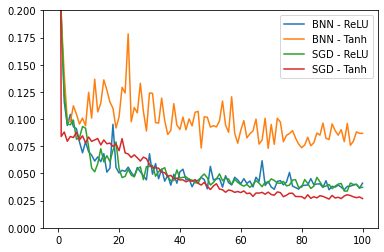

In [29]:
A = np.genfromtxt("result1.txt", dtype = float, delimiter = ',')
B = np.genfromtxt("result2.txt", dtype = float, delimiter = ',')

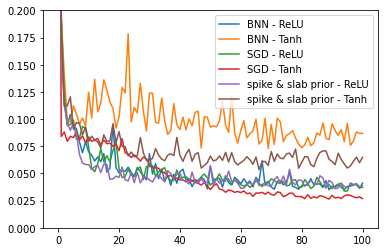

In [30]:
plt.plot(1-np.array(model1.History_learning), label = 'BNN - ReLU')
plt.plot(1-np.array(model2.History_learning), label = 'BNN - Tanh')
plt.plot(1-np.array(model3.History_learning), label = 'SGD - ReLU')
plt.plot(1-np.array(model4.History_learning), label = 'SGD - Tanh')
plt.plot(A, label = 'spike & slab prior - ReLU')
plt.plot(B, label = 'spike & slab prior - Tanh')
plt.ylim([0, .2])
plt.legend()
plt.show()